# CausalVAE
A tutorial on how to do Causal Inference using Variational AutoEncoder.

## Learning Disentanglement Representation
Causal inference is the process to determine the actual effect of treatment on the outcome. To achieve this, we need to estimate the relationship between different variables. This is where learning the disentanglement representation can be helpful. 

According to the definition by *[deep ai](https://deepai.org/machine-learning-glossary-and-terms/disentangled-representation-learning)*:
>Disentangled representation is an unsupervised learning technique that breaks down, or disentangles, each feature into narrowly defined variables and encodes them as separate dimensions.

Using disentanglement representation, we can generate samples that do not exist at the beginning. For example, if our original samples are car a facing front and car b with color red, once we learn the disentangled representation, we can use this net to generate a new car c facing front with color red.

![[]](https://images.deepai.org/glossary-terms/0f4d258be4b8465e93a7cd888ba19543/disentangledrep.jpg)

## Variational Autoencoder
Variational Autoencoder is a popular method to learn disentangled representation. The model has two parts: inference nets as an encoder and generative nets as a decoder. The encoder first maps all the features into a latent space. Then we can generate new features using the decoder. In causal inference, we can use the generative nets to give us counterfactual distributions. For more details about variational autoencoder, you can refer to [*Tutorial on Variational Autoencoders*](https://arxiv.org/abs/1606.05908)

![[]](https://miro.medium.com/max/1400/1*UdOybs9wOe3zW8vDAfj9VA@2x.png)

## Causal Variational Autoencoder
There are three steps to apply Variational Autoencoder to Causal Inference in pratice: 
* Determine the causal model
* Build inference nets and generative nets based on the causal model
* Determine the optimization goal
* Train the model
* Estimate the causal effects based on our nets

### Determine the Causal Model
Assume that we have the following causal model. T is the treatment. y is the outcome. And x are other features other than the treatment. Notice that the causal model is preassumed in practice. It needs field knowledge and expert experience to determine such a causal model. Our neural networks are tools to estimate the parameters of functions. 
![[]](./source/causal_model.png)

### Build inference and generative nets based on the causal model
The causal model is composed of three generative nets and three inference nets. We use $q$ to notate inference nets and $p$ to notate generative nets. Generative nets can generate sample from distributions given conditions. For example, $p(x|z)$ means that we can output the probability distributions of $x$ given $z$.

There are two kinds of features in the data: binary and continuous. Treatment t is ususally a binary data. It should be either 0 or 1. To fit the distribution of binary data, we can use Bernoulli distribution $t \sim B(p ,1)$. The parameter here we want to know is the probability $p$. We can forward a linear layer to a softmax function to get the parameter $p$. The following code shows how to build a binary net in pytorch.



In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import bernoulli, normal

In [27]:
# build a network with binary output
class bin_net(nn.Module):

    def __init__(self, dim_in,dim_h=20, dim_out=1):
        super().__init__()
        self.dim_out = dim_out
        self.input = nn.Linear(dim_in, dim_h)
        self.output = nn.Linear(dim_h, dim_out)

    def forward(self, x):
        x = F.elu(self.input(x))
        # calculate probabilities 
        out_p = torch.sigmoid(self.output(x))
        # generate binary output from bernoulli distribution
        out = bernoulli.Bernoulli(out_p)
        return out

Another kind of data is continuous. For simplicity, we can use normal distributions to reconstruct the data. We need to estimate $\mu$ and $\sigma$ to fit a normal distribution $x \sim N(\mu, \sigma)$. Thus, we build two layers to estimate $\mu$ and $\sigma$ respectively. The following code shows how to build a continuous net in pytorch.

In [28]:
# build a network with continuous output
class cont_net(nn.Module):
    
    def __init__(self,dim_in, dim_h=20, dim_out_con=6):
        super().__init__()
        self.dim_out_con = dim_out_con

        self.input = nn.Linear(dim_in, dim_h)
        # for continuous output, mu and sigma are estimated
        self.output_con_mu = nn.Linear(dim_h, dim_out_con)
        self.output_con_sigma = nn.Linear(dim_h, dim_out_con)
        self.softplus = nn.Softplus()

    def forward(self, z_input):
        z = F.elu(self.input(z_input))
        # for continuous outputs
        mu, sigma = self.output_con_mu(z), self.softplus(self.output_con_sigma(z))
        out = normal.Normal(mu, sigma)
        return out

The next step is to build a network to represent the conditional distribution. Take $p(y|z,t)$ as an example. We want to estimate the distribution of $y$ given $z$ and $t$.

In [29]:
class p_y_zt(nn.Module):

    def __init__(self, dim_in=20, nh=3, dim_h=20, dim_out=1):
        super().__init__()
        self.nh = nh
        self.dim_out = dim_out

        # Separated forwards for different t values, TAR

        self.input_t0 = nn.Linear(dim_in, dim_h)
        # loop through dimensions to create fully con. hidden layers, add params with ModuleList
        self.hidden_t0 = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(nh)])
        self.mu_t0 = nn.Linear(dim_h, dim_out)

        self.input_t1 = nn.Linear(dim_in, dim_h)
        # loop through dimensions to create fully con. hidden layers, add params with ModuleList
        self.hidden_t1 = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(nh)])
        self.mu_t1 = nn.Linear(dim_h, dim_out)

    def forward(self, z, t):
        # Separated forwards for different t values, TAR

        x_t0 = F.elu(self.input_t0(z))
        for i in range(self.nh):
            x_t0 = F.elu(self.hidden_t0[i](x_t0))
        mu_t0 = F.elu(self.mu_t0(x_t0))

        x_t1 = F.elu(self.input_t1(z))
        for i in range(self.nh):
            x_t1 = F.elu(self.hidden_t1[i](x_t1))
        mu_t1 = F.elu(self.mu_t1(x_t1))
        y_bin_p = torch.sigmoid((1-t)*mu_t0 + t * mu_t1)
        return y_bin_p

We can build other networks in the same way.

#### Generative networks

$p(x|z)$

In [30]:
class p_x_z(nn.Module):
    def __init__(self,dim_in=20, nh=3, dim_h=20, dim_out_bin=19, dim_out_con=6):
        super().__init__()
        self.nh = nh
        self.dim_out_bin = dim_out_bin
        self.dim_out_con = dim_out_con

        # dim in is the dim of latent space z
        self.input = nn.Linear(dim_in, dim_h)
        # loop through dimensions to create fully connected hidden layers
        self.hidden = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(nh-1)])
        # output binary layers
        self.output_bin = nn.Linear(dim_h, dim_out_bin)
        # for continuous output, mu and sigma are estimated
        self.output_con_mu = nn.Linear(dim_h, dim_out_con)
        self.output_con_sigma = nn.Linear(dim_h, dim_out_con)
        self.softplus = nn.Softplus()

    def forward(self, z_input):
        z = F.elu(self.input(z_input))
        for i in range(self.nh-1):
            z = F.elu(self.hidden[i](z))
        # for binary output
        x_bin_p = torch.sigmoid(self.output_bin(z))
        x_bin = bernoulli.Bernoulli(x_bin_p)
        # for continuous outputs
        mu, sigma = self.output_con_mu(z), self.softplus(self.output_con_sigma(z))
        x_con = normal.Normal(mu, sigma)
        return x_bin, x_con

$p(t|z)$

In [31]:
class p_t_z(nn.Module):

    def __init__(self, dim_in=20, nh=1, dim_h=20, dim_out=1):
        super().__init__()
        self.nh = nh
        self.dim_out = dim_out

        # dim_in is dim of latent space z
        self.input = nn.Linear(dim_in, dim_h)
        # loop through dimensions to create fully con. hidden layers, add params with ModuleList
        self.hidden = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(nh)])
        self.output = nn.Linear(dim_h, dim_out)

    def forward(self, x):
        x = F.elu(self.input(x))
        for i in range(self.nh):
            x = F.elu(self.hidden[i](x))
        # for binary outputs:
        out_p = torch.sigmoid(self.output(x))

        out = bernoulli.Bernoulli(out_p)
        return out

$p(y|z,t)$

In [32]:

class p_y_zt(nn.Module):

    def __init__(self, dim_in=20, nh=3, dim_h=20, dim_out=1):
        super().__init__()
        self.nh = nh
        self.dim_out = dim_out

        # Separated forwards for different t values, TAR

        self.input_t0 = nn.Linear(dim_in, dim_h)
        # loop through dimensions to create fully con. hidden layers, add params with ModuleList
        self.hidden_t0 = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(nh)])
        self.mu_t0 = nn.Linear(dim_h, dim_out)

        self.input_t1 = nn.Linear(dim_in, dim_h)
        # loop through dimensions to create fully con. hidden layers, add params with ModuleList
        self.hidden_t1 = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(nh)])
        self.mu_t1 = nn.Linear(dim_h, dim_out)

    def forward(self, z, t):
        # Separated forwards for different t values, TAR

        x_t0 = F.elu(self.input_t0(z))
        for i in range(self.nh):
            x_t0 = F.elu(self.hidden_t0[i](x_t0))
        mu_t0 = F.elu(self.mu_t0(x_t0))

        x_t1 = F.elu(self.input_t1(z))
        for i in range(self.nh):
            x_t1 = F.elu(self.hidden_t1[i](x_t1))
        mu_t1 = F.elu(self.mu_t1(x_t1))
        y_bin_p = torch.sigmoid((1-t)*mu_t0 + t * mu_t1)
        return y_bin_p

#### Inference Networks

$q(t|x)$

In [33]:
class q_t_x(nn.Module):

    def __init__(self, dim_in=25, nh=1, dim_h=20, dim_out=1):
        super().__init__()
        self.nh = nh
        self.dim_out = dim_out
        self.input = nn.Linear(dim_in, dim_h)
        self.hidden = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(nh)])
        self.output = nn.Linear(dim_h, dim_out)
        
    def forward(self, x):
        x = F.elu(self.input(x))
        for i in range(self.nh):
            x = F.elu(self.hidden[i](x))
        # for binary outputs:
        out_p = torch.sigmoid(self.output(x))
        out = bernoulli.Bernoulli(out_p)

        return out

$q(y|x,t)$

In [34]:
class q_y_xt(nn.Module):

    def __init__(self, dim_in=25, nh=3, dim_h=20, dim_out=1):
        super().__init__()
        # save required vars
        self.nh = nh
        self.dim_out = dim_out

        # dim_in is dim of data x
        self.input = nn.Linear(dim_in, dim_h)
        # loop through dimensions to create fully con. hidden layers, add params with ModuleList
        self.hidden = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(nh)])
        # separate outputs for different values of t
        self.mu_t0 = nn.Linear(dim_h, dim_out)
        self.mu_t1 = nn.Linear(dim_h, dim_out)

    def forward(self, x, t):
        # Unlike model network, shared parameters with separated heads
        x = F.elu(self.input(x))
        for i in range(self.nh):
            x = F.elu(self.hidden[i](x))
        # only output weights separated
        mu_t0 = self.mu_t0(x)
        mu_t1 = self.mu_t1(x)
        # set mu according to t, sigma set to 1
        y_bin_p = torch.sigmoid((1-t)*mu_t0 + t * mu_t1)
        # set mu according to t value
        return y_bin_p

$q(z|t,y,x)$

In [35]:

class q_z_tyx(nn.Module):

    def __init__(self, dim_in=25+1, nh=3, dim_h=20, dim_out=20):
        super().__init__()
        # dim in is dim of x + dim of y
        # dim_out is dim of latent space z
        self.nh = nh

        # Shared layers with separated output layers

        self.input = nn.Linear(dim_in, dim_h)
        # loop through dimensions to create fully con. hidden layers, add params with ModuleList
        self.hidden = nn.ModuleList([nn.Linear(dim_h, dim_h) for _ in range(nh)])

        self.mu_t0 = nn.Linear(dim_h, dim_out)
        self.mu_t1 = nn.Linear(dim_h, dim_out)
        self.sigma_t0 = nn.Linear(dim_h, dim_out)
        self.sigma_t1 = nn.Linear(dim_h, dim_out)
        self.softplus = nn.Softplus()

    def forward(self, xy, t):
        # Shared layers with separated output layers
        x = F.elu(self.input(xy))
        for i in range(self.nh):
            x = F.elu(self.hidden[i](x))
        mu_t0 = self.mu_t0(x)
        mu_t1 = self.mu_t1(x)
        sigma_t0 = self.softplus(self.sigma_t0(x))
        sigma_t1 = self.softplus(self.sigma_t1(x))

        # Set mu and sigma according to t
        z = normal.Normal((1-t)*mu_t0 + t * mu_t1, (1-t)*sigma_t0 + t * sigma_t1)
        return z

### Optimization Goal

The optimization goal of a VAE is ELBO. In short, the loss function is composed of two parts: reconstruction loss and KL divergence. The reconstruction loss is also called generative loss. It measures whether our generated $x$, $y$ and $t$ are close to the orginal. And KLD is also called latent loss. This loss term penalizes the VAE if it starts to produce latent vectors that are not from the desired distribution. For more details about optimization objective of VAE, please refer to  [*Tutorial on Variational Autoencoders*](https://arxiv.org/abs/1606.05908).

### Training Process
I will use [Kaggle credit card approval prediction dataset](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction) as our example. The task is to analyze whether gender will influence the probabilities of default of credit cards. We use the same causal model as mentioned above. Now the treatment is feature "gender" and y is the delinquency status.

<img src="./source/features.png" width="600" />

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 0
Total: 29.26482582092285
Reconstr_x_bin: 23.016263961791992
Reconstr_x_con: 4.957634449005127
Reconstr_t: 0.6676045656204224
Reconstr_y: 0.5524531602859497
Regularization: 0.0708688423037529
Epoch 1
Total: 26.142833709716797
Reconstr_x_bin: 20.472423553466797
Reconstr_x_con: 4.514923095703125
Reconstr_t: 0.6481339335441589
Reconstr_y: 0.4045935273170471
Regularization: 0.10275883972644806
Epoch 2
Total: 23.183597564697266
Reconstr_x_bin: 17.71431541442871
Reconstr_x_con: 4.337926387786865
Reconstr_t: 0.6360973119735718
Reconstr_y: 0.3583117127418518
Regularization: 0.1369500458240509
Epoch 3
Total: 20.846454620361328
Reconstr_x_bin: 15.437931060791016
Reconstr_x_con: 4.280965805053711
Reconstr_t: 0.6150215268135071
Reconstr_y: 0.3440532982349396
Regularization: 0.16848160326480865
Epoch 4
Total: 19.363256454467773
Reconstr_x_bin: 13.9402494430542
Reconstr_x_con: 4.266636371612549
Reconstr_t:

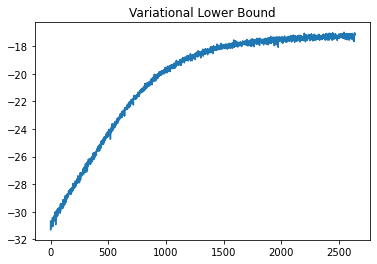

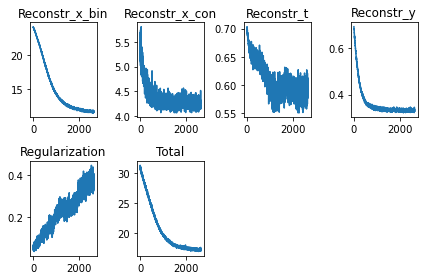

In [3]:
import numpy as np
from models.datasets import CreditDataset
from torch.utils.data import DataLoader
import torch as torch
import torch.nn as nn
from torch.distributions import normal, bernoulli
from torch import optim
from models.networks import p_t_z, p_x_z, p_y_zt, q_t_x, q_y_xt, q_z_tyx
from models.initialize import init_qz
from collections import defaultdict
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Hyper-parameters
M = 1000
epochs = 10
lr = 0.0001
decay = 0.001
print_every = 1
z_dim = 20
h_dim = 64

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# read data
trainset = CreditDataset(M,path="./data/credit_train.csv")
testset = CreditDataset(M, path="./data/credit_test.csv")

(xtr, ttr, ytr) = (trainset.data_x, trainset.data_t, trainset.data_y)
(xte, tte, yte) = (testset.data_x, testset.data_t, testset.data_y)


binfeats = trainset.bin_feats
confeats = trainset.con_feats
perm = binfeats+confeats

xtr, xte = xtr[:, perm], xte[:, perm]

x_dim = len(binfeats) + len(confeats)

# initialize the networks
p_x_z_dist = p_x_z(dim_in=z_dim, nh=1, dim_h=h_dim, dim_out_bin=len(binfeats), dim_out_con=len(confeats)).to(device)
p_t_z_dist = p_t_z(dim_in=z_dim, nh=1, dim_h=h_dim, dim_out=1).to(device)
p_y_zt_dist = p_y_zt(dim_in=z_dim, nh=1, dim_h=h_dim, dim_out=1).to(device)
q_t_x_dist = q_t_x(dim_in=x_dim, nh=1, dim_h=h_dim, dim_out=1).to(device)
q_y_xt_dist = q_y_xt(dim_in=x_dim, nh=1, dim_h=h_dim, dim_out=1).to(device)
q_z_tyx_dist = q_z_tyx(dim_in=x_dim+1, nh=1, dim_h=h_dim, dim_out=z_dim).to(device)

p_z_dist = normal.Normal(torch.zeros(z_dim).to(device), torch.ones(z_dim).to(device))

params = list(p_x_z_dist.parameters()) + \
         list(p_t_z_dist.parameters()) + \
         list(p_y_zt_dist.parameters()) + \
         list(q_t_x_dist.parameters()) + \
         list(q_y_xt_dist.parameters()) + \
         list(q_z_tyx_dist.parameters())

# init q_z inference
q_z_tyx_dist = init_qz(q_z_tyx_dist, p_z_dist, ytr, ttr, xtr)

optimizer = optim.Adam(params, lr=lr, weight_decay=decay)

n_epoch, n_iter_per_epoch, idx = epochs, 10 * int(xtr.shape[0] / M), list(range(xtr.shape[0]))

loss = defaultdict(list)

 # store loss per epoch
loss_history_store = {'Total': [],
                    'Reconstr_x_bin': [],
                    'Reconstr_x_con': [],
                    'Reconstr_t': [],
                    'Reconstr_y': [],
                    'Regularization': []}

for epoch in range(n_epoch+1):
    # print('Epoch: %i/%i' % (epoch, n_epoch))
    loss_sum = 0.
    # shuffle index
    np.random.shuffle(idx)
    # take random batch for training

    loss_epoch_store = {'Total': [],
                    'Reconstr_x_bin': [],
                    'Reconstr_x_con': [],
                    'Reconstr_t': [],
                    'Reconstr_y': [],
                    'Regularization': []}

    for j in range(n_iter_per_epoch):
        # select random batch
        batch = np.random.choice(idx, M)
        x_train, y_train, t_train = torch.FloatTensor(xtr[batch]), torch.FloatTensor(ytr[batch]), \
                                        torch.FloatTensor(ttr[batch])
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        t_train = t_train.to(device)

        # inferred distribution over z
        xy = torch.cat((x_train, y_train), 1)
        z_infer = q_z_tyx_dist(xy=xy, t=t_train)
        # use a single sample to approximate expectation in lowerbound
        z_infer_sample = z_infer.sample()

        # RECONSTRUCTION LOSS
        # p(x|z)
        x_bin, x_con = p_x_z_dist(z_infer_sample)
        l1 = x_bin.log_prob(x_train[:, :len(binfeats)]).sum(1)
        loss['Reconstr_x_bin'].append(l1.mean().cpu().detach().float())
        loss_epoch_store['Reconstr_x_bin'].append(l1.mean().cpu().detach().float())
        l2 = x_con.log_prob(x_train[:, -len(confeats):]).sum(1)
        loss['Reconstr_x_con'].append(l2.mean().cpu().detach().float())
        loss_epoch_store['Reconstr_x_con'].append(l2.mean().cpu().detach().float())
        # p(t|z)
        t = p_t_z_dist(z_infer_sample)
        l3 = t.log_prob(t_train).squeeze()
        loss['Reconstr_t'].append(l3.mean().cpu().detach().float())
        loss_epoch_store['Reconstr_t'].append(l3.mean().cpu().detach().float())
        # p(y|t,z)
        # for training use t_train, in out-of-sample prediction this becomes t_infer
        y = p_y_zt_dist(z_infer_sample, t_train)
        y = bernoulli.Bernoulli(y)
        l4 = y.log_prob(y_train).squeeze()
        loss['Reconstr_y'].append(l4.mean().cpu().detach().float())
        loss_epoch_store['Reconstr_y'].append(l4.mean().cpu().detach().float())
        # REGULARIZATION LOSS
        # p(z) - q(z|x,t,y)
        # approximate KL
        l5 = (p_z_dist.log_prob(z_infer_sample) - z_infer.log_prob(z_infer_sample)).sum(1)
        # Analytic KL (seems to make overall performance less stable)
        loss['Regularization'].append(l5.mean().cpu().detach().float())
        loss_epoch_store['Regularization'].append(l5.mean().cpu().detach().float())

        # Total objective
        # inner sum to calculate loss per item, torch.mean over batch
        loss_mean = torch.mean(l1 + l2 + l3 + l4 + l5)
        loss['Total'].append(loss_mean.cpu().detach().numpy())
        loss_epoch_store['Total'].append(loss_mean.cpu().detach().numpy())
        objective = -loss_mean

        optimizer.zero_grad()
        # Calculate gradients
        objective.backward()
        # Update step
        optimizer.step()

    loss_history_store['Total'].append(-np.mean(loss_epoch_store['Total']))
    loss_history_store['Reconstr_x_bin'].append(-np.mean(loss_epoch_store['Reconstr_x_bin']))
    loss_history_store['Reconstr_x_con'].append(-np.mean(loss_epoch_store['Reconstr_x_con']))
    loss_history_store['Reconstr_t'].append(-np.mean(loss_epoch_store['Reconstr_t']))
    loss_history_store['Reconstr_y'].append(-np.mean(loss_epoch_store['Reconstr_y']))
    loss_history_store['Regularization'].append(-np.mean(loss_epoch_store['Regularization']))

    if epoch % print_every == 0:
        print('Epoch %i' % epoch)
        for k, v in loss_history_store.items():
            print("{}: {}".format(k, v[-1]))

plt.figure()
plt.plot(np.array(loss['Total']), label='Total')
plt.title('Variational Lower Bound')
plt.show()

plt.figure()
subidx = 1
for key, value in loss.items():
    plt.subplot(2, 4, subidx)
    plt.tight_layout()
    plt.plot(-np.array(value), label=key)
    plt.title(key)
    subidx += 1
plt.show()

### Analyze the causal effects
We can estimate the causal effect of gender by computing:$$TE = p(y|t=1, z) - p(y|t=1, z)$$

In [7]:
def get_y0_y1(p_y_zt_dist, q_y_xt_dist, q_z_tyx_dist, x_train, t_train, L=1):
    y_infer = q_y_xt_dist(x_train.float(), t_train.float())
    
    # use inferred y
    xy = torch.cat((x_train.float(), y_infer), 1)
    z_infer = q_z_tyx_dist(xy=xy, t=t_train.float()).sample()
    # Manually input zeros and ones
    y0 = p_y_zt_dist(z_infer, torch.zeros(z_infer.shape))
    y1 = p_y_zt_dist(z_infer, torch.ones(z_infer.shape))

    return y0.cpu().detach().numpy(), y1.cpu().detach().numpy(), z_infer.cpu().detach().numpy()

def y_counterfact(t, y0, y1):
    ypred = (1 - t) * y0 + t * y1
    ypred_cf = t * y0 + (1 - t) * y1
    return ypred, ypred_cf

In [8]:
y0_new = np.zeros(shape=(0,1))
y1_new = np.zeros(shape=(0,1))
t_new = np.zeros(shape=(0,1))
ypred_new = np.zeros(shape=(0,1))
ypred_cf_new = np.zeros(shape=(0,1))
x_new = np.zeros(shape=(0,37))
y_new = np.zeros(shape=(0,1))
t_new = np.zeros(shape=(0,1))
z_new = np.zeros(shape=(0,20))

n_epoch, n_iter_per_epoch, idx = epochs, 1*int(xtr.shape[0] / M), list(range(xtr.shape[0]))
for j in range(n_iter_per_epoch):
    batch = np.random.choice(idx, M)
    x_tr, y_tr, t_tr = torch.FloatTensor(xtr[batch]), torch.FloatTensor(ytr[batch]), \
                                        torch.FloatTensor(ttr[batch])
    x_tr = x_tr.to(device)
    y_tr = y_tr.to(device)
    t_tr = t_tr.to(device)
    t = ttr[batch]
    y0_tr, y1_tr, z_tr = get_y0_y1(p_y_zt_dist, q_y_xt_dist, q_z_tyx_dist, x_tr, y_tr)
    z_new = np.concatenate([z_new, z_tr])
    ypred, ypred_cf = y_counterfact(t, y0_tr, y1_tr)
    y0_new = np.concatenate([y0_new, y0_tr.mean(axis=1).reshape(-1,1)])
    y1_new = np.concatenate([y1_new, y1_tr.mean(axis=1).reshape(-1,1)])
    t_new = np.concatenate([t_new, t])
    ypred_new = np.concatenate([ypred_new, ypred.mean(axis=1).reshape(-1,1)])
    ypred_cf_new = np.concatenate([ypred_cf_new, ypred_cf.mean(axis=1).reshape(-1,1)])
    x_new = np.concatenate([x_new, xtr[batch]])
    y_new = np.concatenate([y_new, ytr[batch]])

xt_new = np.zeros(shape=(x_new.shape[0], 38))
xt_new[:,0] = t_new.flatten()
xt_new[:,1:] = x_new

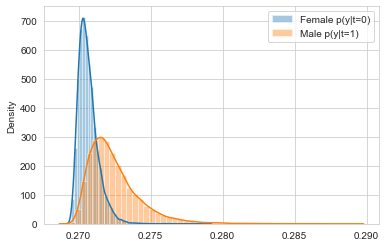

In [12]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
sns.distplot(y0_new.flatten(), label='Female p(y|t=0)')
sns.distplot(y1_new.flatten(), label='Male p(y|t=1)')
plt.legend()
plt.show()